In [71]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
%matplotlib inline

In [31]:
df = pd.read_csv('index_raw.csv')
pop = pd.read_csv('other/census_clean.csv')

In [32]:
print(len(df))
df.drop(df[df.zip == 10015].index, inplace = True)
print(len(df))
df = df.reset_index(drop = True)

3190
3179


In [33]:
years = df.year.unique()

In [34]:
year_df_dict = {}
for year in years:
    year_df_dict[year] = df[df.year == year]

In [35]:
for year in year_df_dict.keys():
    year_df_dict[year] = year_df_dict[year].merge(pop, on = ['zip'])
    year_df_dict[year].dropna(inplace = True)
    year_df_dict[year].reset_index(drop = True, inplace = True)

In [36]:
arts_providers = ['independent_artists', 'art_firms', 'arts_organizations']
arts_dollars = ['total_revenue', 'total_compensation', 'total_expenses', 'contributed_revenue']
government_support = ['federal_awards', 'federal_dollars', 'state_awards', 'state_dollars']
index_variables = arts_providers + arts_dollars + government_support

In [37]:
zip_transformation = {10165: 10017,
                     10170:10017,
                     10173:10017,
                     10167:10017,
                     10174:10017,
                     10168:10017,
                     10169:10017,
                     10177:10017,
                     10172:10017,
                     10171:10017,
                     10110:10036, 
                     10020:10019,
                     10112:10019,
                     10103:10019,
                     10162:10075,
                     10153:10022,
                     10152:10022,
                     10154:10022,
                     10110:10036,
                     10199:10001,
                     10119:10001,
                     10278:10007,
                     10279:10007,
                     10271:10005,
                     10111:10019,
                     10115:10027,
                     10311:10314,
                     11351:11356,
                     11359:11360,
                     11371:11369
                     }
print(len(zip_transformation))
zip_check = pd.read_csv('other/zip_check.csv')
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10015].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10065].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 10075].index, inplace = True)
print(len(zip_check))
zip_check.drop(zip_check[zip_check.zip == 11005].index, inplace = True)
print(len(zip_check))
zip_check.reset_index(inplace = True)
for zip_value, index in zip(zip_check.zip, zip_check.index):
    if zip_value in zip_transformation.keys():
        print(zip_value)
    zip_transformation[zip_value] = int(zip_check.iloc[index, 3])
print(len(zip_transformation))

29
28
27
26
25
24
53


In [38]:
def replace_zips(df):
    # operates on a dataframe, iterates over rows, if the zip of the row is a bad zipcode, it first adds all the
    # values of that row to the bigger zip then drops that row
    iterdf = df.copy()
    new_df = df.copy()
    for old_zip in iterdf.zip:
        if old_zip in zip_transformation.keys():
            new_zip = zip_transformation[old_zip]
            for column_name in index_variables + ['population']:
                try:
                    old_zip_value = df.loc[df.zip == old_zip, column_name].item()
                except ValueError:
                    old_zip_value = 0
                try:
                    new_zip_value = df.loc[df.zip == new_zip, column_name].item()
                except ValueError:
                    new_zip_value = 0
                new_df.loc[new_df.zip == new_zip, column_name] = old_zip_value + new_zip_value
    for zip_code in zip_transformation.keys():
        new_df.drop(new_df[new_df.zip == zip_code].index, inplace = True)
    new_df.reset_index(drop = True, inplace = True)
    return new_df            

In [39]:
for year in year_df_dict.keys():
    year_df_dict[year] = replace_zips(year_df_dict[year])

In [40]:
# per capita
for year in year_df_dict.keys():
    copy_df = year_df_dict[year].copy()
    for variable in index_variables:
        year_df_dict[year][variable] = copy_df[variable] / copy_df.population

In [41]:
# standard normal scaling
sns_dict = year_df_dict
for year in sns_dict.keys():
    scaler = StandardScaler()
    snscaled = pd.DataFrame(scaler.fit_transform(sns_dict[year][index_variables]), columns = index_variables)
    snscaled['zip'] = year_df_dict[year].zip
    snscaled['year'] = year_df_dict[year].year
    snscaled['population'] = year_df_dict[year].population
    snscaled = snscaled[year_df_dict[year].columns.values]
    sns_dict[year] = snscaled
    

In [42]:
# pca and index
for year in sns_dict.keys():
    pca = PCA(n_components = 1)
    sns_dict[year]['pca_arts_providers'] = pca.fit_transform(sns_dict[year][arts_providers])
    sns_dict[year]['pca_arts_dollars'] = pca.fit_transform(sns_dict[year][arts_dollars])
    sns_dict[year]['pca_government_support'] = pca.fit_transform(sns_dict[year][government_support])
    sns_dict[year]['vibrancy'] = 0.45*sns_dict[year]['pca_arts_providers'] + 0.45*sns_dict[year]['pca_arts_dollars'] + \
                                    0.1*sns_dict[year]['pca_government_support']

In [43]:
sns_2015 = sns_dict[2015]

In [44]:
zip_shapes = gpd.read_file('nyc_zips/nyc-zip-code-tabulation-areas-polygons.geojson')
zip_shapes.postalCode = zip_shapes.postalCode.apply(int)
zip_shapes = zip_shapes[['postalCode', 'geometry']]
zip_shapes.columns = ['zip', 'geometry']
zip_shapes = zip_shapes.merge(sns_2015, on = 'zip')

In [54]:
zip_shapes['rank'] = zip_shapes.vibrancy.rank(method = 'dense')

<Figure size 1728x1296 with 0 Axes>

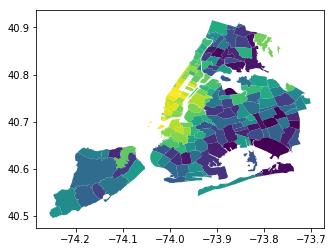

In [115]:
plt.figure(figsize = (24,18))
zip_shapes.plot(column = 'rank')
plt.savefig('vibrancy_rank.png')

In [105]:
zip_shapes.vibrancy.sort_values()

150    -0.480310
17     -0.480310
152    -0.480310
95     -0.480310
9      -0.480030
134    -0.479857
173    -0.479856
55     -0.477211
171    -0.476903
65     -0.476399
41     -0.475531
14     -0.475299
20     -0.475284
53     -0.474642
33     -0.474526
52     -0.474293
137    -0.472738
56     -0.472063
139    -0.471904
153    -0.471321
146    -0.471149
63     -0.470915
156    -0.470804
50     -0.470640
13     -0.470523
7      -0.470030
27     -0.469823
34     -0.468390
37     -0.467883
158    -0.467493
         ...    
90      0.077301
125     0.121633
108     0.129259
82      0.134771
111     0.139243
183     0.262826
102     0.384543
135     0.402032
122     0.600534
129     0.754837
140     0.918949
107     0.921154
185     0.935012
71      1.176339
119     1.197357
113     1.414191
127     1.609679
120     1.736012
85      2.178437
114     2.252277
106     3.102715
83      3.846539
105     3.873147
130     4.209770
131     4.209770
132     4.209770
133     4.209770
184     4.3701

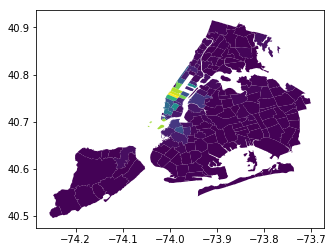

In [114]:
mmscaler = MinMaxScaler(feature_range = (0,5))
mms = zip_shapes.copy()
mms.loc[mms.vibrancy.idxmax(), 'vibrancy'] = 5
# mms.vibrancy.sort_values()
# mms['vibrancy'] = pd.DataFrame(mmscaler.fit_transform(np.array(zip_shapes.vibrancy).reshape(-1,1)))
# plt.figure(figsize = (12,9))
# ax = plt.subplot(2,2,1)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# plt.title('Vibrancy')
# plt.hist(mms.vibrancy)
mms.plot(column = 'vibrancy')
plt.savefig('hand_adjusted_vibrancy.png')

In [92]:
sns_dict[2015]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca1,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy
0,10001,2015,3.480186,2.482793,2.305868,0.528833,0.865169,1.051302,0.250196,2.096190,0.887272,2.351064,1.575452,21111,4.771827,4.771827,1.349965,3.479081,3.102715
1,10002,2015,0.007483,-0.135031,-0.054491,-0.126555,-0.069795,-0.099843,-0.111814,0.073518,-0.004237,0.151514,0.163839,81410,-0.104389,-0.104389,-0.204090,0.195110,-0.119305
2,10003,2015,4.579054,0.752356,1.207203,0.298751,0.651035,0.580170,0.239497,0.883696,0.306192,1.006898,0.853371,56024,3.778120,3.778120,0.885230,1.537697,2.252277
3,10004,2015,1.921914,0.478145,4.231880,0.964897,1.569002,1.596713,0.354815,8.935339,3.766136,7.320350,9.014852,3089,3.862438,3.862438,2.247123,14.604673,4.209770
4,10005,2015,0.504062,0.789607,0.607389,0.258721,-0.063185,0.572202,0.418299,0.036662,-0.122710,0.094402,-0.112400,7135,1.095892,1.095892,0.592377,-0.048838,0.754837
5,10006,2015,1.688338,0.021088,-0.081466,0.828913,2.178352,1.146113,1.321213,-0.227808,-0.158481,-0.244396,-0.222468,3011,0.938558,0.938558,2.733624,-0.428030,1.609679
6,10007,2015,0.648372,0.705023,0.945298,-0.060143,-0.052260,-0.015057,-0.102667,0.852328,0.175250,0.101529,-0.052422,6988,1.329238,1.329238,-0.114730,0.540056,0.600534
7,10009,2015,0.170960,-0.186934,-0.037655,-0.185895,-0.239233,-0.239373,-0.163893,-0.074011,-0.108973,0.031433,-0.070458,61347,-0.029677,-0.029677,-0.414360,-0.109144,-0.210731
8,10010,2015,0.663760,0.164334,0.161347,-0.135773,-0.172932,-0.140194,-0.133512,0.009296,0.491405,-0.092526,-0.118881,31834,0.571080,0.571080,-0.291197,0.132965,0.139243
9,10011,2015,1.558204,0.431796,0.631953,0.125814,0.288733,0.365119,0.061583,0.216330,0.045262,0.435196,0.286092,50984,1.515252,1.515252,0.421217,0.497430,0.921154


In [84]:
pca = PCA(n_components = 1)
sns_2015['pca1'] = pca.fit_transform(sns_2015[arts_providers])

In [120]:
zip_shapes.loc[zip_shapes.vibrancy.idxmax(), :]

zip                                                                   10018
geometry                  POLYGON ((-74.00170164222186 40.76138075542977...
year                                                                   2015
independent_artists                                                 9.24661
art_firms                                                           9.93882
arts_organizations                                                  11.1552
total_revenue                                                       11.7182
total_compensation                                                  9.61466
total_expenses                                                      9.61864
contributed_revenue                                                 12.3715
federal_awards                                                      8.79398
federal_dollars                                                     12.4747
state_awards                                                        9.92604
state_dollar

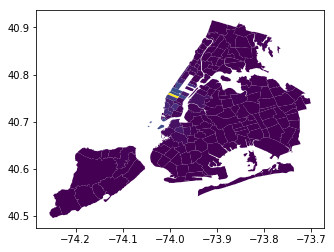

In [116]:
zip_shapes.plot(column = 'vibrancy')
plt.savefig('vibrancy_map.png')

In [87]:
sns_2015[['zip', 'independent_artists', 'art_firms', 'arts_organizations', 'pca1']]

,zip,independent_artists,art_firms,arts_organizations,pca1
0,10001,3.480186,2.482793,2.305868,4.771827
1,10002,0.007483,-0.135031,-0.054491,-0.104389
2,10003,4.579054,0.752356,1.207203,3.778120
3,10004,1.921914,0.478145,4.231880,3.862438
4,10005,0.504062,0.789607,0.607389,1.095892
5,10006,1.688338,0.021088,-0.081466,0.938558
6,10007,0.648372,0.705023,0.945298,1.329238
7,10009,0.170960,-0.186934,-0.037655,-0.029677
8,10010,0.663760,0.164334,0.161347,0.571080
9,10011,1.558204,0.431796,0.631953,1.515252


(array([162.,   7.,   5.,   1.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([-0.52798167,  1.27751312,  3.08300791,  4.8885027 ,  6.69399749,
         8.49949228, 10.30498707, 12.11048186, 13.91597665, 15.72147144,
        17.52696622]),
 <a list of 10 Patch objects>)

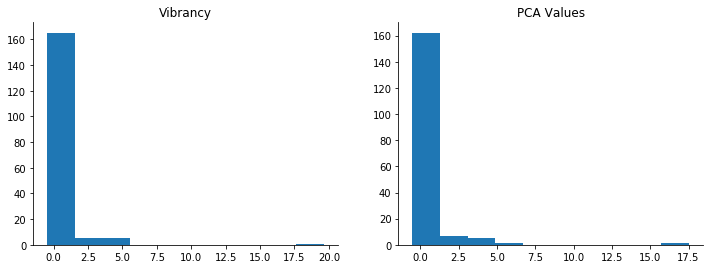

In [93]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Vibrancy')
plt.hist(sns_dict[2015].vibrancy)
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('PCA Values')
plt.hist(sns_2015.pca1)

In [49]:
df_2015.sort_values('art_firms', ascending = False).head()

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
32,10036,2015,76,11060,81,179577275,61834077.0,170072591,88008429.0,25,690000.0,116,1906580.0,24711
16,10019,2015,89,7453,92,831196376,165107122.0,504015244,431234485.0,13,610000.0,80,1577172.0,42870
19,10023,2015,74,4923,79,944887157,359202794.0,820543845,443172549.0,26,1411800.0,78,1892638.0,60998
0,10001,2015,92,3475,75,84630476,25471145.0,81483751,33636684.0,26,865000.0,136,1846234.0,21111
2,10003,2015,314,3328,116,153597493,54646287.0,138633998,87018430.0,33,1020000.0,174,2931764.0,56024


(array([ 4.,  8.,  1.,  7.,  6.,  9., 10.,  9.,  7., 11., 14., 11.,  6.,
         5.,  5.,  7., 10.,  2.,  8.,  1.,  6.,  7.,  2.,  6.,  3.,  5.,
         2.,  3.,  0.,  1.]),
 array([   184.        ,   3842.23333333,   7500.46666667,  11158.7       ,
         14816.93333333,  18475.16666667,  22133.4       ,  25791.63333333,
         29449.86666667,  33108.1       ,  36766.33333333,  40424.56666667,
         44082.8       ,  47741.03333333,  51399.26666667,  55057.5       ,
         58715.73333333,  62373.96666667,  66032.2       ,  69690.43333333,
         73348.66666667,  77006.9       ,  80665.13333333,  84323.36666667,
         87981.6       ,  91639.83333333,  95298.06666667,  98956.3       ,
        102614.53333333, 106272.76666667, 109931.        ]),
 <a list of 30 Patch objects>)

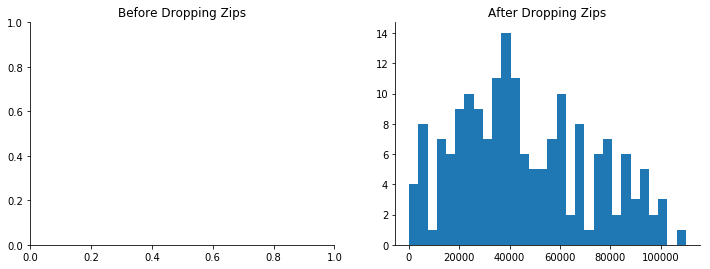

In [54]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Before Dropping Zips')
# plt.hist(df.loc[df.year == 2015, 'independent_artists'])
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('After Dropping Zips')
plt.hist(df_2015.population, bins = 30)

In [53]:
df_2015.sort_values('population')

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
165,11430,2015,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0,184
5,10006,2015,7,45,1,17046930,7900625.0,12461149,16882164.0,0,0.0,0,0.0,3011
3,10004,2015,8,132,19,19802029,6073647.0,16876457,6132813.0,15,475000.0,58,1387942.0,3089
86,11109,2015,2,2,0,0,0.0,0,0.0,0,0.0,0,0.0,3523
175,11697,2015,0,0,1,4498,0.0,4163,660.0,0,0.0,0,0.0,4079
67,10464,2015,1,9,3,654926,179656.0,648113,213795.0,0,0.0,2,10000.0,4534
41,10282,2015,1,0,2,268060,0.0,280216,268060.0,1,60000.0,2,56000.0,4783
38,10069,2015,4,2,2,27750,0.0,26700,23750.0,0,0.0,0,0.0,5199
15,10018,2015,57,3231,81,343206650,55690494.0,151900462,245849182.0,25,2588268.0,132,2290730.0,5229
132,11363,2015,1,11,4,352181,0.0,339223,196223.0,0,0.0,2,26000.0,6988


In [55]:
pc_2015 = df_2015.copy()
for variable in index_variables:
    pc_2015[variable] = df_2015[variable] / df_2015.population

NameError: name 'df_2015' is not defined

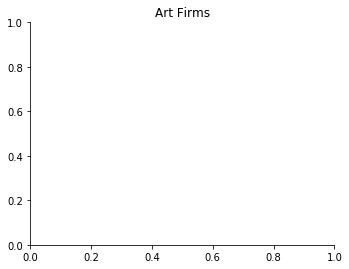

In [121]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Art Firms')
plt.hist(df_2015.art_firms)
plt.savefig('Art_Firms_Hist')

(array([158.,   9.,   5.,   2.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([-0.36059653,  0.60012371,  1.56084395,  2.52156419,  3.48228443,
         4.44300467,  5.40372491,  6.36444514,  7.32516538,  8.28588562,
         9.24660586]),
 <a list of 10 Patch objects>)

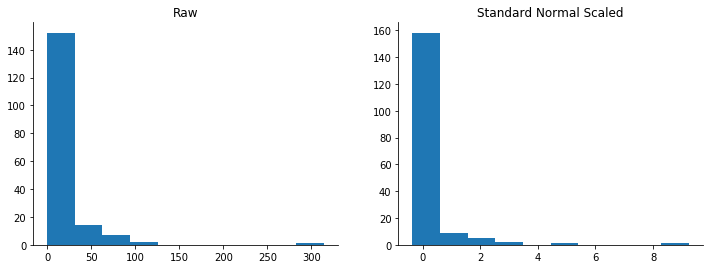

In [78]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Raw')
plt.hist(df_2015.independent_artists)
ax = plt.subplot(2,2,2)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Standard Normal Scaled')
plt.hist(snscaled.independent_artists)

In [ ]:
for year in year_df_dict.keys():
    for variable in index_variables:

In [123]:
for variable in index_variables:
    df_2015[variable] = df_2015[variable] / df_2015.population

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
99,10010,2005,43,521,32,12489138,2061374.0,10350620,4313655.0,6,559485.0,52,556800.0


In [60]:
df_2015.independent_artists = (df_2015.independent_artists - df_2015.independent_artists.mean()) / df_2015.independent_artists.std()

In [61]:
df_2015.art_firms = (df_2015.art_firms - df_2015.art_firms.mean()) / df_2015.art_firms.std()
df_2015.arts_organizations = (df_2015.arts_organizations - df_2015.arts_organizations.mean()) / df_2015.arts_organizations.std()

In [62]:
df[['zip', 'total_revenue']].sort_values(by = 'total_revenue', ascending = False)

,zip,total_revenue
252,10023,944887157
246,10023,876708491
245,10023,865443903
244,10023,835564883
208,10019,830719742
247,10023,822526785
248,10023,813812807
251,10023,780803237
243,10023,763124566
250,10023,754344669


In [74]:
df[(df.year==2015) & (df.zip == 10015)]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars
164,10015,2015,0,0,0,0,0.0,0,0.0,0,0.0,0,0.0


In [64]:
df_2015[df_2015.zip == 11430]

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population
194,11430,2015,-0.120039,-0.088494,-0.124335,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,184


In [65]:
len(df[df.year == 2015].zip.unique())

290

In [66]:
df_2015[['zip', 'population', 'total_revenue']].sort_values(by = 'total_revenue', ascending = True)

,zip,population,total_revenue
104,10475,40931,0.000000
50,10162,1685,0.000000
58,10173,2,0.000000
177,11411,18556,0.000000
61,10199,9,0.000000
166,11369,38615,0.000000
112,11109,3523,0.000000
182,11416,24861,0.000000
185,11419,47211,0.000000
76,10310,24962,0.000000


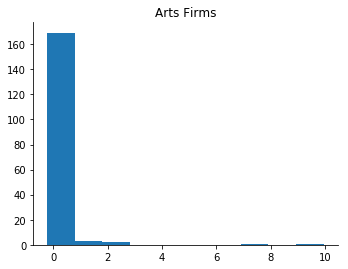

In [125]:
plt.figure(figsize = (12,9))
ax = plt.subplot(2,2,1)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.title('Arts Firms')
plt.hist(sns_dict[2015]['art_firms'])
plt.savefig('Art Firms Per Capita Hist')

In [128]:
sns_dict[2015].sort_values(by = 'art_firms')

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy
175,11697,2015,-0.360597,-0.224739,-0.145926,-0.198841,-0.252663,-0.261103,-0.174945,-0.227808,-0.158481,-0.244396,-0.222468,4079,-0.421417,-0.443960,-0.428030,-0.432222
157,11420,2015,-0.360597,-0.224739,-0.260806,-0.198099,-0.252663,-0.259755,-0.173880,-0.227808,-0.158481,-0.244396,-0.222468,44354,-0.488781,-0.442384,-0.428030,-0.461827
41,10282,2015,-0.176333,-0.224739,-0.017692,-0.188865,-0.252663,-0.241524,-0.160033,0.166713,0.161683,-0.075930,0.018234,4783,-0.239883,-0.421747,0.132192,-0.284514
43,10302,2015,-0.268252,-0.224739,-0.288823,-0.198972,-0.252663,-0.261446,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,19088,-0.451917,-0.444219,-0.428030,-0.446065
55,10452,2015,-0.360597,-0.224739,-0.298153,-0.197444,-0.250095,-0.258381,-0.172813,-0.202772,-0.155095,-0.201633,-0.196010,75371,-0.510680,-0.439554,-0.378585,-0.465464
58,10455,2015,-0.338377,-0.224739,-0.308969,-0.198100,-0.251962,-0.259927,-0.174182,-0.180235,-0.145612,-0.244396,-0.222468,39665,-0.504200,-0.442269,-0.397822,-0.465693
60,10457,2015,-0.360597,-0.224739,-0.317143,-0.198602,-0.252663,-0.260455,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,70496,-0.521816,-0.443536,-0.428030,-0.477211
159,11422,2015,-0.331629,-0.224739,-0.278929,-0.198584,-0.252663,-0.260541,-0.174727,-0.227808,-0.158481,-0.244396,-0.222468,30425,-0.482691,-0.443441,-0.428030,-0.459562
74,10471,2015,-0.322147,-0.224739,-0.165961,-0.197549,-0.252663,-0.258882,-0.173622,-0.145486,-0.136212,-0.103785,-0.153587,22922,-0.410976,-0.441541,-0.269256,-0.410558
76,10473,2015,-0.345536,-0.224739,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,58519,-0.519290,-0.444256,-0.428030,-0.476399


In [16]:
pca = PCA(n_components = 1)

In [17]:
component1 = pca.fit_transform(df_2015[['independent_artists', 'art_firms', 'arts_organizations']])

KeyError: ('independent_artists', 'art_firms', 'arts_organizations')

In [12]:
df_2015[['independent_artists', 'art_firms', 'arts_organizations']]

,independent_artists,art_firms,arts_organizations
0,-0.107480,-0.019358,-0.082952
1,-0.118836,-0.086204,-0.120044
2,-0.103894,-0.063554,-0.100227
3,-0.112579,-0.070553,-0.052718
4,-0.117213,-0.062721,-0.111280
5,-0.113342,-0.082219,-0.120468
6,-0.116741,-0.064763,-0.104340
7,-0.118301,-0.087529,-0.119780
8,-0.116691,-0.078563,-0.116654
9,-0.113767,-0.071736,-0.109262


In [133]:
test_geo = gpd.read_file('zip_2015.geojson')

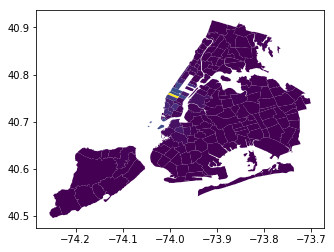

In [134]:
test_geo.plot(column = 'vibrancy')

In [135]:
test_geo

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank,geometry
0,11372,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,-0.171172,-0.146990,-0.208120,-0.206425,66636,-0.420657,-0.441045,-0.367298,-0.424496,99.0,POLYGON ((-73.86942457284175 40.74915687096787...
1,11004,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,-0.227808,-0.158481,-0.186907,-0.190199,14016,-0.445943,-0.443368,-0.382414,-0.438432,88.0,POLYGON ((-73.71068374074007 40.75004039450917...
2,11426,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,-0.227808,-0.158481,-0.244396,-0.222468,17590,-0.453847,-0.441101,-0.428030,-0.445530,78.0,POLYGON ((-73.72270447144122 40.75373371438336...
3,11365,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,-0.227808,-0.158481,-0.244396,-0.222468,42252,-0.446694,-0.435538,-0.428030,-0.439807,86.0,POLYGON ((-73.81088634744755 40.72717187575918...
4,11373,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,-0.227808,-0.158481,-0.244396,-0.222468,100820,-0.491838,-0.441761,-0.428030,-0.462923,37.0,POLYGON ((-73.88722098467157 40.72752618766134...
5,11375,2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,-0.227808,-0.158481,-0.244396,-0.222468,68733,-0.429395,-0.442633,-0.428030,-0.435216,91.0,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
6,11427,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,23593,-0.467990,-0.444256,-0.428030,-0.453314,62.0,POLYGON ((-73.74168681424477 40.73682340115314...
7,11374,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,-0.227808,-0.158481,-0.244396,-0.222468,43600,-0.505255,-0.444138,-0.428030,-0.470030,23.0,POLYGON ((-73.86451198956482 40.73407164841783...
8,11366,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,13532,-0.479277,-0.444024,-0.428030,-0.458289,53.0,POLYGON ((-73.77010678596534 40.73177920848852...
9,11423,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,29987,-0.527358,-0.444256,-0.428030,-0.480030,2.0,POLYGON ((-73.77010678596534 40.73177920848852...


In [131]:
zip_shapes

,zip,geometry,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,2015,-0.294466,-0.217827,-0.216414,-0.197251,-0.252663,-0.258483,-0.173327,-0.171172,-0.146990,-0.208120,-0.206425,66636,-0.420657,-0.441045,-0.367298,-0.424496,99.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,2015,-0.360597,-0.189532,-0.221881,-0.198517,-0.252663,-0.260965,-0.174219,-0.227808,-0.158481,-0.186907,-0.190199,14016,-0.445943,-0.443368,-0.382414,-0.438432,88.0
2,11426,POLYGON ((-73.72270447144122 40.75373371438336...,2015,-0.360597,-0.224739,-0.201231,-0.197336,-0.252663,-0.258757,-0.173077,-0.227808,-0.158481,-0.244396,-0.222468,17590,-0.453847,-0.441101,-0.428030,-0.445530,78.0
3,11365,POLYGON ((-73.81088634744755 40.72717187575918...,2015,-0.339738,-0.211503,-0.222392,-0.195621,-0.247874,-0.254279,-0.172958,-0.227808,-0.158481,-0.244396,-0.222468,42252,-0.446694,-0.435538,-0.428030,-0.439807,86.0
4,11373,POLYGON ((-73.88722098467157 40.72752618766134...,2015,-0.343113,-0.224413,-0.283543,-0.197870,-0.252169,-0.259503,-0.173610,-0.227808,-0.158481,-0.244396,-0.222468,100820,-0.491838,-0.441761,-0.428030,-0.462923,37.0
5,11375,"POLYGON ((-73.8562474640478 40.7367227854824, ...",2015,-0.270838,-0.209184,-0.262948,-0.198167,-0.252156,-0.259805,-0.174779,-0.227808,-0.158481,-0.244396,-0.222468,68733,-0.429395,-0.442633,-0.428030,-0.435216,91.0
6,11427,POLYGON ((-73.74168681424477 40.73682340115314...,2015,-0.323241,-0.221950,-0.264819,-0.199040,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,23593,-0.467990,-0.444256,-0.428030,-0.453314,62.0
7,11374,POLYGON ((-73.86451198956482 40.73407164841783...,2015,-0.360597,-0.219835,-0.293654,-0.198988,-0.252663,-0.261344,-0.174911,-0.227808,-0.158481,-0.244396,-0.222468,43600,-0.505255,-0.444138,-0.428030,-0.470030,23.0
8,11366,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.195566,-0.272878,-0.198845,-0.252663,-0.261184,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,13532,-0.479277,-0.444024,-0.428030,-0.458289,53.0
9,11423,POLYGON ((-73.77010678596534 40.73177920848852...,2015,-0.360597,-0.223642,-0.327658,-0.199041,-0.252663,-0.261450,-0.174989,-0.227808,-0.158481,-0.244396,-0.222468,29987,-0.527358,-0.444256,-0.428030,-0.480030,2.0


In [136]:
test_2010 = gpd.read_file('zip_2010.geojson')

In [140]:
test_2010

,zip,year,independent_artists,art_firms,arts_organizations,total_revenue,total_compensation,total_expenses,contributed_revenue,federal_awards,federal_dollars,state_awards,state_dollars,population,pca_arts_providers,pca_arts_dollars,pca_government_support,vibrancy,rank,geometry
0,11372,2010,-0.317538,-0.222253,-0.212608,-0.240023,-0.227015,-0.244129,-0.258363,-0.232053,-0.259793,-0.181527,-0.199307,66636,-0.436212,-0.484781,-0.436498,-0.458097,90.0,POLYGON ((-73.86942457284175 40.74915687096787...
1,11004,2010,-0.347687,-0.175051,-0.294746,-0.246244,-0.231830,-0.248383,-0.266256,-0.232053,-0.259793,-0.232341,-0.215810,14016,-0.476515,-0.496371,-0.469940,-0.484793,37.0,POLYGON ((-73.71068374074007 40.75004039450917...
2,11426,2010,-0.347687,-0.232931,-0.250294,-0.244898,-0.231830,-0.247145,-0.263357,-0.232053,-0.259793,-0.232341,-0.215810,17590,-0.482159,-0.493628,-0.469940,-0.486098,34.0,POLYGON ((-73.72270447144122 40.75373371438336...
3,11365,2010,-0.323913,-0.228075,-0.202217,-0.240594,-0.231830,-0.243258,-0.260053,-0.232053,-0.259793,-0.232341,-0.215810,42252,-0.437147,-0.487875,-0.469940,-0.463254,84.0,POLYGON ((-73.81088634744755 40.72717187575918...
4,11373,2010,-0.347687,-0.235777,-0.286990,-0.246129,-0.231830,-0.248208,-0.266233,-0.232053,-0.259793,-0.232341,-0.215810,100820,-0.505155,-0.496214,-0.469940,-0.497610,8.0,POLYGON ((-73.88722098467157 40.72752618766134...
5,11375,2010,-0.260000,-0.217931,-0.249242,-0.242579,-0.231830,-0.246173,-0.265567,-0.232053,-0.259793,-0.232341,-0.215810,68733,-0.420721,-0.493085,-0.469940,-0.458207,89.0,"POLYGON ((-73.8562474640478 40.7367227854824, ..."
6,11427,2010,-0.305111,-0.233655,-0.261604,-0.245795,-0.231830,-0.247389,-0.265748,-0.232053,-0.259793,-0.232341,-0.215810,23593,-0.463609,-0.495394,-0.469940,-0.478545,61.0,POLYGON ((-73.74168681424477 40.73682340115314...
7,11374,2010,-0.324648,-0.224294,-0.276812,-0.245699,-0.231830,-0.248188,-0.265083,-0.232053,-0.259793,-0.232341,-0.215810,43600,-0.479107,-0.495414,-0.469940,-0.485529,35.0,POLYGON ((-73.86451198956482 40.73407164841783...
8,11366,2010,-0.273456,-0.191379,-0.236964,-0.243883,-0.231830,-0.248119,-0.261176,-0.232053,-0.259793,-0.232341,-0.215810,13532,-0.407120,-0.492519,-0.469940,-0.451832,96.0,POLYGON ((-73.77010678596534 40.73177920848852...
9,11423,2010,-0.347687,-0.234108,-0.294746,-0.246244,-0.231830,-0.248383,-0.266256,-0.232053,-0.259793,-0.232341,-0.215810,29987,-0.508774,-0.496371,-0.469940,-0.499309,4.0,POLYGON ((-73.77010678596534 40.73177920848852...
